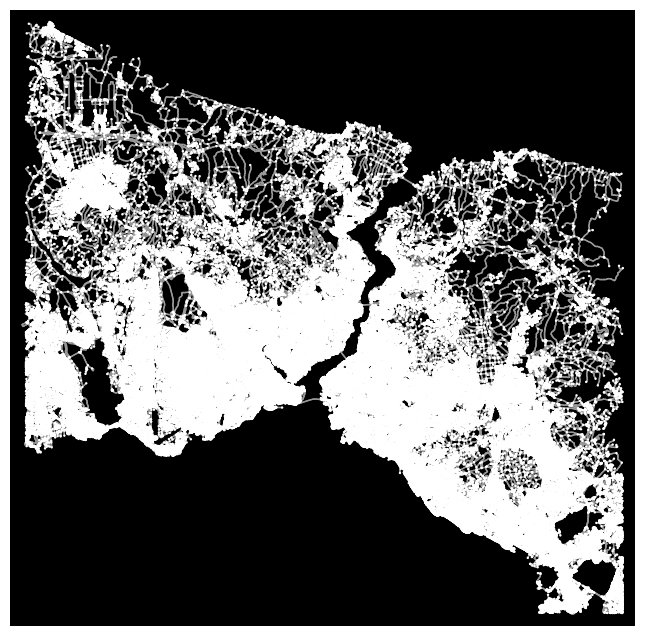

In [31]:
import osmnx as ox  #1.2.2

center_point = (41.0824261, 29.0114145)

G = ox.graph_from_point(center_point, dist=30000, network_type="all")
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# Plot the graph
fig, ax = ox.plot_graph(G, bgcolor="black", node_size=3, node_color="white", figsize=(16, 8))

In [6]:
# Splitting graph to nodes and edges
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G, nodes=True, edges=True)

# Adding osmid column to nodes
nodes_gdf['osmid'] = G.nodes.keys()

# Adding start and end nodes to edges
start_nodes = []
end_nodes = []

for u, v, data in G.edges(data=True):
    start_nodes.append(u)
    end_nodes.append(v)

edges_gdf['start_node'] = start_nodes
edges_gdf['end_node'] = end_nodes

# Saving nodes and edges to csv
nodes_gdf.to_csv('nodes.csv', index=False)
edges_gdf.to_csv('edges.csv', index=False)

In [1]:
import pandas as pd
import networkx as nx

traffic_collision = pd.read_csv('data/traffic_collisions.csv')
edges = pd.read_csv('edges.csv')

edges['traffic_collisions_number'] = [0] * 419616

def get_collisions_along_edge(u, v, accidents_data):
    # Extract the coordinates of the nodes u and v
    node_u_coords = (G.nodes[u]['y'], G.nodes[u]['x'])
    node_v_coords = (G.nodes[v]['y'], G.nodes[v]['x'])

    # Create a LineString representing the edge (u, v)
    edge_line = LineString([node_u_coords, node_v_coords])

    # Convert your accidents_data to a GeoDataFrame with Point geometries
    accidents_geo = gpd.GeoDataFrame(
        accidents_data,
        geometry=gpd.points_from_xy(accidents_data['latitude'], accidents_data['longitude'])
    )
    
    tolerance = 0.001
    # Spatial join to associate each collision with the nearest edge
    collisions_on_edge = accidents_geo[accidents_geo.geometry.distance(edge_line) < tolerance].shape[0]

    return collisions_on_edge

# Adding traffic_collisions_number to edges
for (u, v, data) in G.edges(data=True):
        collisions_on_edge = get_collisions_along_edge(u, v, traffic_collision)
        edges.loc[i, 'traffic_collisions_number'] = collisions_on_edge
        
edges.to_csv('edges.csv', index=False)

KeyboardInterrupt: 

In [ ]:
import pandas as pd

hospitals = pd.read_csv('data/hospitals.csv')

# Finding nearest node for every hospital
for i in range(len(hospitals)):
    hospital_coordinates = (hospitals.loc[i, 'longitude'], hospitals.loc[i, 'latitude'])
    nearest_node = ox.distance.nearest_nodes(G, hospital_coordinates[0], hospital_coordinates[1])
    hospitals.loc[i, 'nearest_node'] = int(nearest_node)

hospitals.to_csv('data/hospitals.csv', index=False)

In [ ]:
import pandas as pd

nodes = pd.read_csv('nodes.csv')
edges = pd.read_csv('edges.csv')

for i in range(len(edges)):
    start_node = nodes[nodes['osmid'] == edges.loc[i, 'start_node']]
    end_node = nodes[nodes['osmid'] == edges.loc[i, 'end_node']]

    edges.loc[i, 'start_node_latitude'] = start_node['y'].values[0] if not start_node.empty else None
    edges.loc[i, 'start_node_longitude'] = start_node['x'].values[0] if not start_node.empty else None

    edges.loc[i, 'end_node_latitude'] = end_node['y'].values[0] if not end_node.empty else None
    edges.loc[i, 'end_node_longitude'] = end_node['x'].values[0] if not end_node.empty else None

edges.to_csv('edges.csv', index=False)


In [2]:
from shapely.geometry import LineString, Point
import geopandas as gpd
import pandas as pd

hospitals = pd.read_csv('data/hospitals.csv')
edges = pd.read_csv('edges.csv')


# Calculating min distance to hospital for every edge
for k in range(len(edges)):
    print(k)
    min_distance = 999999 

    for i in range(len(hospitals)):
        hospital_coords = (hospitals.loc[i, 'latitude'], hospitals.loc[i, 'longitude'])  # Replace with actual coordinates
        edge_geometry = LineString([(edges.loc[k, 'start_node_latitude'], edges.loc[k, 'start_node_longitude']), (edges.loc[k, 'end_node_latitude'], edges.loc[k, 'end_node_longitude'])])
        node_point = Point(hospital_coords)
        distance_to_edge = node_point.distance(edge_geometry)
        if distance_to_edge < min_distance:
            min_distance = distance_to_edge
            edges.loc[k, 'distance_to_hospital'] = min_distance

edges.to_csv('edges.csv', index=False)


KeyboardInterrupt: 

In [3]:
import pandas as pd
edges = pd.read_csv('edges.csv')

traffic_collisions_number_max = max(edges['traffic_collisions_number'])
distance_to_hospital_max = max(edges['distance_to_hospital'])

# Normalizing data
for i in range(len(edges)):
    edges.loc[i, 'traffic_collisions_number'] = edges.loc[i, 'traffic_collisions_number'] / traffic_collisions_number_max
    edges.loc[i, 'distance_to_hospital'] = edges.loc[i, 'distance_to_hospital'] / distance_to_hospital_max

edges.to_csv('edges.csv', index=False)

C:\Users\nik\AppData\Local\Temp\ipykernel_20340\2364841958.py:2: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  edges = pd.read_csv('edges.csv')


In [30]:
import pandas as pd
import networkx as nx

# Read nodes and edges from CSV files
nodes_df = pd.read_csv('nodes.csv')
edges_df = pd.read_csv('edges.csv')

# Create an empty graph
G_imported = nx.Graph()

# Add nodes to the graph
for index, row in nodes_df.iterrows():
    G_imported.add_node(
        row['osmid'],
        geometry=row['geometry'],
        highway=row['highway'],
        ref=row['ref'],
        street_count=row['street_count'],
        x=row['x'],
        y=row['y'],
    )  # Adjust attributes as needed

for index, row in edges_df.iterrows():
    G_imported.add_edge(
        u_of_edge=row['start_node'],
        v_of_edge=row['end_node'],
        osmid=row['osmid'],
        oneway=row['oneway'],
        lanes=row['lanes'],
        highway=row['highway'],
        maxspeed=row['maxspeed'],
        reversed=row['reversed'],
        length=row['length'],
        bridge=row['bridge'],
        geometry=row['geometry'],
        speed_kph=row['speed_kph'],
        travel_time=row['travel_time'],
        traffic_collisions_number=row['traffic_collisions_number'],
        distance_to_hospital=row['distance_to_hospital'],
    )

G_imported.graph['crs'] = 'EPSG:4326'
# Now G_imported is a networkx Graph with nodes and edges, including additional attributes


C:\Users\nik\AppData\Local\Temp\ipykernel_15452\1808380297.py:6: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  edges_df = pd.read_csv('edges.csv')


In [6]:
import pandas as pd
edges = pd.read_csv('edges.csv')

# Define weight for every edge
edges['weight'] = [0] * 419616
edges['weight'] = edges['traffic_collisions_number'] * 2 + edges['distance_to_hospital'] * 3
edges.to_csv('edges.csv', index=False)

C:\Users\nik\AppData\Local\Temp\ipykernel_20340\1806782470.py:2: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  edges = pd.read_csv('edges.csv')


In [14]:
import folium
shortest_path_nodes = nx.shortest_path(G, source=243882825, target=245014318,
                                       method='dijkstra', weight='lenght')
path_coordinates = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in shortest_path_nodes]

start_point = (41.026938, 28.9262909)
end_point = (41.027648, 28.9317068)
map_center = [start_point[0], start_point[1]]
my_map = folium.Map(location=map_center, zoom_start=13)

# Add a Polyline to the map using the path coordinates
folium.PolyLine(
    locations=path_coordinates,
    color="blue",
    weight=5,
    opacity=0.7,
).add_to(my_map)

# Add markers for start and end points
folium.Marker(start_point, popup="Start Point").add_to(my_map)
folium.Marker(end_point, popup="End Point").add_to(my_map)

# Save the map to an HTML file or display it in Jupyter Notebook
my_map.save("route_map.html")

In [6]:
print(path_coordinates)

[(40.8126604, 29.3685772)]


In [16]:
import pandas as pd

nodes_df = pd.read_csv('nodes.csv')
edges_df = pd.read_csv('edges.csv')

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
for index, row in nodes_df.iterrows():
    G.add_node(
        row['osmid'],
        geometry=row['geometry'],
        highway=row['highway'],
        ref=row['ref'],
        street_count=row['street_count'],
        x=row['x'],
        y=row['y'],
    )  # Adjust attributes as needed

for index, row in edges_df.iterrows():
    G.add_edge(
        u_of_edge=row['start_node'],
        v_of_edge=row['end_node'],
        osmid=row['osmid'],
        oneway=row['oneway'],
        lanes=row['lanes'],
        highway=row['highway'],
        maxspeed=row['maxspeed'],
        reversed=row['reversed'],
        length=row['length'],
        bridge=row['bridge'],
        geometry=row['geometry'],
        speed_kph=row['speed_kph'],
        travel_time=row['travel_time'],
        traffic_collisions_number=row['traffic_collisions_number'],
        distance_to_hospital=row['distance_to_hospital'],
    )

C:\Users\nik\AppData\Local\Temp\ipykernel_11356\3719201406.py:4: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  edges_df = pd.read_csv('edges.csv')


In [3]:
import folium

# Define origin and destionation points
start_point = (28.949284, 41.013821)
end_point = (28.655473, 41.036035)

# Finding nearest nodes for points
start_node = ox.distance.nearest_nodes(G, start_point[0], start_point[1])
end_node = ox.distance.nearest_nodes(G, end_point[0], end_point[1])

# Find shortest path between two nodes
shortest_path_nodes = nx.shortest_path(G, source=start_node, target=end_node,
                                       method='dijkstra', weight='weight')

# Convert nodes to coordinates
path_coordinates = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in shortest_path_nodes]

# Plot path
map_center = [start_point[0], start_point[1]]
my_map = folium.Map(location=map_center, zoom_start=13)

# Add a Polyline to the map using the path coordinates
folium.PolyLine(
    locations=path_coordinates,
    color="blue",
    weight=5,
    opacity=0.7,
).add_to(my_map)

# Add markers for start and end points
folium.Marker(start_point, popup="Start Point").add_to(my_map)
folium.Marker(end_point, popup="End Point").add_to(my_map)

# Save the map to an HTML file or display it in Jupyter Notebook
my_map.save("route_map.html")

AttributeError: partially initialized module 'pandas' has no attribute 'core' (most likely due to a circular import)